# Hyperparameters Used
- $\gamma$: Discount Factor
- Model Architecture
    - 2 Fully-connected layers
    - 4 states feed into a 128 node hidden-layer
        - dropout = 0.6 (hyperparameter)
        - RELU activation function
    - Hidden layer feeds into a 4 node output-layer
        - softmax activation function
- Optimizer:
    - Adam Optimizer
        - default params
        - $\alpha$: learning-rate
-$\beta$: Exponentially-weighted average coefficient

-Source: https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py

In [1]:
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
%matplotlib notebook

# Some system setup

In [2]:
gamma = 0.99 # discount factor
seed  = 543
render = False
log_interval = 10

env = gym.make('CartPole-v1')
#env = gym.make('InvertedDoublePendulum-v2')
env.seed(seed)
torch.manual_seed(seed)

# Deep Learning Model
The following class defines the neural network used to train our agent.
We use a two layer fully-connected model with droupout on the first layer, followed by a RELU activation function.
The second layer uses a softmax activation function to estimate the best action to take in the current state.

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Model and optimizer setup
Here we set up the model and choose to optimize it with an Adam Optimizer with learning rate $\alpha=0.01$.

In [4]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1.2e-2)
eps = np.finfo(np.float32).eps.item()

# Helper Functions

In [5]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

def sim_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    actions = policy(state)
    _, action = actions.max(1)
    return action.item()

def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

def sim():
    tot_reward = 0
    state = env.reset()
    for t in range(1, 10000):
        action = sim_action(state)
        state, reward, done, _ = env.step(action)
        tot_reward += reward
        env.render()
        if done:
            print(tot_reward)
            break

In [6]:
duration = []
#env.spec.max_episode_steps = 100
#env.spec.max_episode_steps

# Training
We train the model in the cell below until our average reward surpasses the built in reward threshold. 
We use an exponentially weighted average with $\beta = 0.4$ on the running reward.

In [7]:
running_reward = 10
for i_episode in count(1):
    state, ep_reward = env.reset(), 0
    for t in range(1, 20000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        if render:
            env.render()
        policy.rewards.append(reward)
        ep_reward += reward
        if done:
            duration.append(t)
            break

    running_reward = 0.04 * ep_reward + (1 - 0.04) * running_reward
    finish_episode()
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
              i_episode, ep_reward, running_reward))
        #print(action)
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
              "the last episode runs to {} time steps!".format(running_reward, t))
        env.close()
        break

Episode 10	Last reward: 26.00	Average reward: 15.08
Episode 20	Last reward: 14.00	Average reward: 14.35
Episode 30	Last reward: 43.00	Average reward: 17.88
Episode 40	Last reward: 22.00	Average reward: 18.44
Episode 50	Last reward: 23.00	Average reward: 18.59
Episode 60	Last reward: 28.00	Average reward: 23.62
Episode 70	Last reward: 62.00	Average reward: 29.03
Episode 80	Last reward: 38.00	Average reward: 37.22
Episode 90	Last reward: 119.00	Average reward: 45.48
Episode 100	Last reward: 42.00	Average reward: 45.30
Episode 110	Last reward: 93.00	Average reward: 51.09
Episode 120	Last reward: 111.00	Average reward: 98.60
Episode 130	Last reward: 60.00	Average reward: 101.64
Episode 140	Last reward: 32.00	Average reward: 97.90
Episode 150	Last reward: 106.00	Average reward: 108.51
Episode 160	Last reward: 33.00	Average reward: 88.98
Episode 170	Last reward: 34.00	Average reward: 72.48
Episode 180	Last reward: 55.00	Average reward: 61.80
Episode 190	Last reward: 93.00	Average reward: 71.

# Training performance
The plot below is a measure of training performance. As the model is trained, it should on average be able to run longer without "failing".

Text(0.5, 1.0, 'Training Duration')

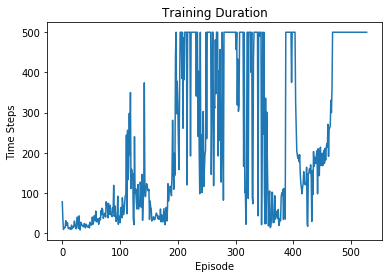

In [8]:
plt.plot(duration)
plt.xlabel("Episode")
plt.ylabel("Time Steps")
plt.title("Training Duration")

In [9]:
from gym import wrappers
from time import time # just to have timestamps in the files

# Simulate Environment and Record Current Model

In [10]:
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, './videos/' + str(time()) + '/')
sim()
#sudo apt-get install ffmpeg

500.0


# Save the model

In [11]:
torch.save(policy.state_dict(), "./models/model_lr_1.2en2.pth")